# Email Classification Model Training

This notebook demonstrates the process of training a custom Machine Learning model for the Email Agent. 
We use **TF-IDF Vectorization** and a **Stochastic Gradient Descent (SGD) Classifier** to categorize emails into: 
- Work
- Finance
- Travel
- Spam

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os
import random

%matplotlib inline

## 1. Synthetic Data Generation
Since we cannot use real private emails, we generate a synthetic dataset with characteristic keywords for each category.

In [20]:
def generate_dataset(n_samples=1000):
    data = []
    
    # Standard Keywords
    work_keywords = ["meeting", "project", "deadline", "report", "sync", "quarterly review", "status update", "client", "deliverable"]
    finance_keywords = ["invoice", "payment", "receipt", "salary", "expense", "budget", "tax", "wire transfer"]
    travel_keywords = ["flight", "hotel", "itinerary", "booking", "reservation", "gate change", "boarding pass"]
    spam_keywords = ["lottery", "winner", "prize", "inheritance", "viagra", "casino", "crypto", "urgent business proposal"]

    # --- HELPER FUNCTIONS FOR CONSISTENCY ---
    # We use functions to ensure the text structure is IDENTICAL for both clean and noisy data.
    def get_work_text():
        return f"Subject: {random.choice(work_keywords)} needed. Body: Review attached document."
    def get_finance_text():
        return f"Subject: {random.choice(finance_keywords)} processed. Body: Payment sent."
    def get_travel_text():
        return f"Subject: {random.choice(travel_keywords)} confirmed. Body: Trip details attached."
    def get_spam_text():
        return f"Subject: {random.choice(spam_keywords)} alert. Body: Click this link now."

    # --- 1. Clean Data (95% of data) ---
    for _ in range(int(n_samples * 0.95) // 4):
        data.append({"text": get_work_text(), "label": "Work"})
        data.append({"text": get_finance_text(), "label": "Finance"})
        data.append({"text": get_travel_text(), "label": "Travel"})
        data.append({"text": get_spam_text(), "label": "Spam"})

    # ---------------------------------------------------------
    # 2. HUMAN ERROR (Label Noise) - 5%
    # ---------------------------------------------------------
    # We iterate and intentionally assign WRONG labels to the EXACT SAME text structures generated above.
    # This creates inevitable confusion.
    
    # Spam emails mislabeled as Work
    for _ in range(int(n_samples * 0.025)):
        data.append({"text": get_spam_text(), "label": "Work"}) # <-- The text is SPAM, but label is WORK
        
    # Travel emails mislabeled as Finance
    for _ in range(int(n_samples * 0.025)):
        data.append({"text": get_travel_text(), "label": "Finance"}) # <-- The text is TRAVEL, but label is FINANCE

    return pd.DataFrame(data)

df = generate_dataset(2000)
print(f"Generated {len(df)} samples.")
df.tail()

Generated 2000 samples.


,text,label
1995,Subject: itinerary confirmed. Body: Trip detai...,Finance
1996,Subject: flight confirmed. Body: Trip details ...,Finance
1997,Subject: booking confirmed. Body: Trip details...,Finance
1998,Subject: hotel confirmed. Body: Trip details a...,Finance
1999,Subject: gate change confirmed. Body: Trip det...,Finance


## 2. Model Training
We split the data into training and testing sets (80/20) and train the pipeline.

In [21]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

print("Training model...")
pipeline.fit(X_train, y_train)
print("Training complete.")

Training model...
Training complete.


## 3. Evaluation Metrics
We evaluate the model using accuracy, precision, recall, and F1-score.

In [22]:
y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

     Finance       1.00      0.91      0.95       101
        Spam       0.86      1.00      0.93        94
      Travel       0.92      1.00      0.96       104
        Work       1.00      0.85      0.92       101

    accuracy                           0.94       400
   macro avg       0.95      0.94      0.94       400
weighted avg       0.95      0.94      0.94       400



## 4. Confusion Matrix
Visualizing true positives vs false positives.

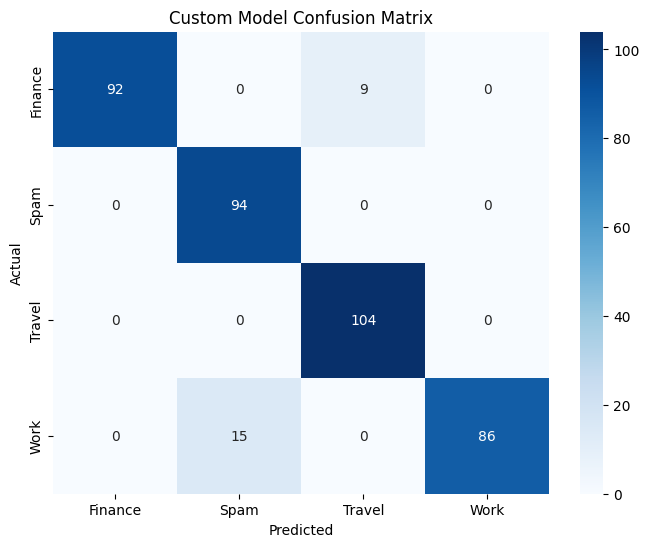

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title('Custom Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 5. Save Model
Serializing the model for production use.

In [24]:
if not os.path.exists("../data"):
    os.makedirs("../data")
    
model_path = "../data/email_classifier.joblib"
joblib.dump(pipeline, model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../data/email_classifier.joblib
